In [61]:
import numpy as np
from product_analytics.variant_evaluation import _sample_posterior

In [197]:
from statsmodels.stats.proportion import proportions_ztest
import numpy as np

def run_ztest(successes_a: int, successes_b: int, nobs: int) -> float:
    

    count = np.array([successes_a, successes_b])
    nobs_arr = np.array([nobs, nobs])
    
    try:
        _, p_val = proportions_ztest(count, nobs_arr, alternative='two-sided')
    except Exception:
        p_val = 1.0
    
    return p_val


In [180]:
def evaluate_single_trial(
    true_p_a: float,
    true_p_b: float,
    sample_size: int,
    bayes_draws: int
):
    
    # Simulate successes
    successes_a = np.random.binomial(sample_size, true_p_a)
    successes_b = np.random.binomial(sample_size, true_p_b)
 
    # Run z-test
    p_val = run_ztest(successes_a, successes_b, sample_size)

    # Bayesian samples (Beta(1,1) prior implied)
    samples_a = _sample_posterior(successes_a, sample_size, 1, 1, bayes_draws)
    samples_b = _sample_posterior(successes_b, sample_size, 1, 1, bayes_draws)

    # Always compute P(B > A)
    p_b_better = (samples_b > samples_a).mean()

    return p_val, p_b_better, 'B' if (successes_a < successes_b) else ( 'A=B' if (successes_a == successes_b) else 'A' )



In [176]:
def run_experiment(
    true_p_a: float,
    true_p_b: float,
    sample_size: int,
    bayes_draws: int,
    repetitions: int,
    seed: int = 42
):
    np.random.seed(seed)
    p_values = []
    bayes_probs = []
    winners = []

    for _ in range(repetitions):
        p_val, bayes_prob, winner = evaluate_single_trial(
            true_p_a=true_p_a,
            true_p_b=true_p_b,
            sample_size=sample_size,
            bayes_draws=bayes_draws
        )
        p_values.append(p_val)
        bayes_probs.append(bayes_prob)
        winners.append(winner)

    return np.array(p_values), np.array(bayes_probs), winners


In [266]:
def summarize(p_vals, bayes_probs, true_winner, winners):
    winners = np.array(winners)
    correct_mask = (winners == true_winner)
    correct_p_vals = p_vals[correct_mask]

    # Initialize everything
    freq_correct = bayes_correct = 0.0
    freq_wrong = bayes_wrong = 0.0

    if true_winner == 'B':
        freq_correct = ((winners == 'B') & (p_vals <= 0.05)).sum() / p_vals.size
        freq_wrong = ((winners == 'A') & (p_vals <= 0.05)).sum() / p_vals.size

        bayes_correct = (bayes_probs >= 0.975).sum() / bayes_probs.size
        bayes_wrong = (bayes_probs <= 0.025).sum() / bayes_probs.size

    elif true_winner == 'A':
        freq_correct = ((winners == 'A') & (p_vals <= 0.05)).sum() / p_vals.size
        freq_wrong = ((winners == 'B') & (p_vals <= 0.05)).sum() / p_vals.size

        bayes_correct = (bayes_probs <= 0.025).sum() / bayes_probs.size
        bayes_wrong = (bayes_probs >= 0.975).sum() / bayes_probs.size

    else:  # A = B
        freq_correct = (p_vals > 0.05).sum() / p_vals.size
        freq_wrong = (p_vals <= 0.05).sum() / p_vals.size

        bayes_correct = ((bayes_probs > 0.025) & (bayes_probs < 0.975)).sum() / bayes_probs.size
        bayes_wrong = ((bayes_probs <= 0.025) | (bayes_probs >= 0.975)).sum() / bayes_probs.size

    return {
        "freq_correct": freq_correct,
        "freq_wrong": freq_wrong,
        "bayes_correct": bayes_correct,
        "bayes_wrong": bayes_wrong
    }


In [289]:
def evaluate_experiment(true_p_a, true_p_b, sample_size=10, bayes_draws=10000, repetitions=10000):
    # Run the experiment simulation
    p_vals, bayes_probs, winners = run_experiment(
        true_p_a=true_p_a,
        true_p_b=true_p_b,
        sample_size=sample_size,
        bayes_draws=bayes_draws,
        repetitions=repetitions
    )

    # Determine the true winner
    if true_p_a < true_p_b:
        true_winner = 'B'
    elif true_p_a > true_p_b:
        true_winner = 'A'
    else:
        true_winner = 'A=B'

    # Summarize the results
    
    return  summarize(p_vals, bayes_probs, true_winner, winners)

    

In [268]:
scenarios = [
    {"name": "No effect (small n)",        "p_a": 0.05, "p_b": 0.05, "n": 10},
    {"name": "B better (small n)",         "p_a": 0.05, "p_b": 0.10, "n": 10},
    {"name": "B better (large n)",         "p_a": 0.05, "p_b": 0.10, "n": 1000},
    {"name": "A better (small n)",         "p_a": 0.10, "p_b": 0.05, "n": 10},
    {"name": "A better (large n)",         "p_a": 0.10, "p_b": 0.05, "n": 1000},
    {"name": "Small diff (medium n)",      "p_a": 0.05, "p_b": 0.06, "n": 50},
    {"name": "No effect (large n)",        "p_a": 0.05, "p_b": 0.05, "n": 2000},
]

results = []

for i, scenario in enumerate(scenarios, 1):
    name = scenario["name"]
    p_a = scenario["p_a"]
    p_b = scenario["p_b"]
    n = scenario["n"]

    print(f"\nScenario {i}: {name}")

    result = evaluate_experiment(p_a, p_b, sample_size=n)

    print(f"Frequentist - True Positive Rate:  {result['freq_correct']:.4f}")
    print(f"Frequentist - False Positive Rate: {result['freq_wrong']:.4f}")
    print(f"Bayesian     - True Positive Rate:  {result['bayes_correct']:.4f}")
    print(f"Bayesian     - False Positive Rate: {result['bayes_wrong']:.4f}")

    results.append({
        "Scenario": i,
        "Name": name,
        "p_a": p_a,
        "p_b": p_b,
        "Sample Size": n,
        "Freq TPR": result["freq_correct"],
        "Freq FPR": result["freq_wrong"],
        "Bayes TPR": result["bayes_correct"],
        "Bayes FPR": result["bayes_wrong"],
    })






Scenario 1: No effect (small n)
Frequentist - True Positive Rate:  0.6464
Frequentist - False Positive Rate: 0.0006
Bayesian     - True Positive Rate:  0.9994
Bayesian     - False Positive Rate: 0.0006

Scenario 2: B better (small n)
Frequentist - True Positive Rate:  0.0064
Frequentist - False Positive Rate: 0.0006
Bayesian     - True Positive Rate:  0.0064
Bayesian     - False Positive Rate: 0.0006

Scenario 3: B better (large n)
Frequentist - True Positive Rate:  0.9884
Frequentist - False Positive Rate: 0.0000
Bayesian     - True Positive Rate:  0.9886
Bayesian     - False Positive Rate: 0.0000

Scenario 4: A better (small n)
Frequentist - True Positive Rate:  0.0080
Frequentist - False Positive Rate: 0.0004
Bayesian     - True Positive Rate:  0.0080
Bayesian     - False Positive Rate: 0.0004

Scenario 5: A better (large n)
Frequentist - True Positive Rate:  0.9910
Frequentist - False Positive Rate: 0.0000
Bayesian     - True Positive Rate:  0.9906
Bayesian     - False Positive Ra

/Users/andreasadlichhammer/miniconda3/envs/product_analytics/lib/python3.12/site-packages/statsmodels/stats/weightstats.py:792: RuntimeWarning: invalid value encountered in scalar divide
  zstat = value / std


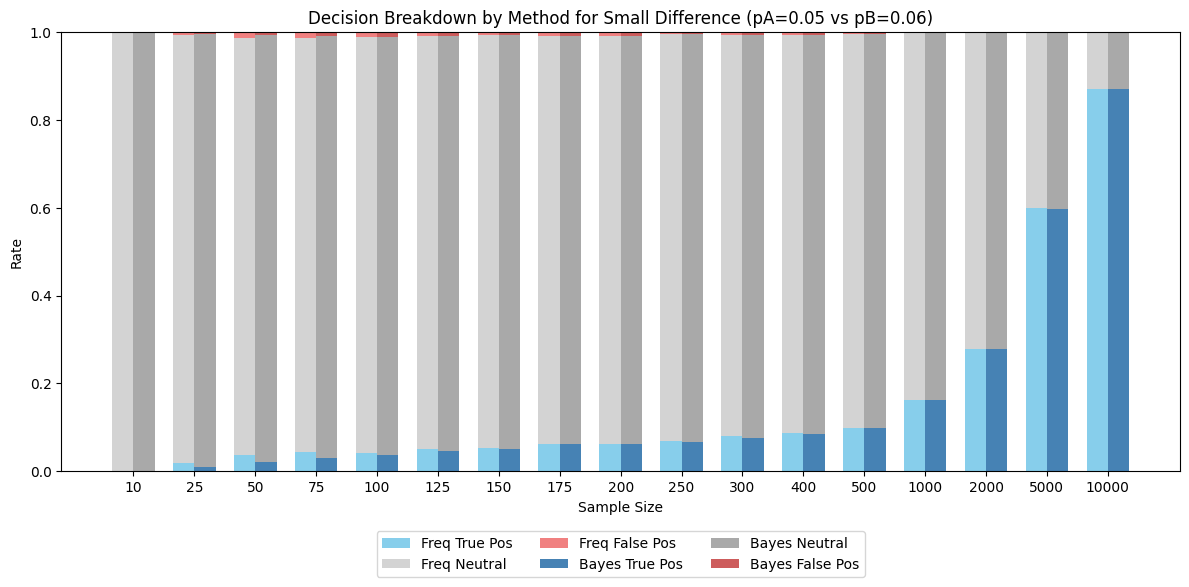

,Sample Size,Freq TPR,Freq FPR,Freq Neutral,Bayes TPR,Bayes FPR,Bayes Neutral
0,10,0.0011,0.0001,0.9988,0.0011,0.0001,0.9988
1,25,0.0184,0.0073,0.9743,0.0107,0.0035,0.9858
2,50,0.0362,0.0134,0.9504,0.0216,0.0063,0.9721
3,75,0.0429,0.0146,0.9425,0.0314,0.0089,0.9597
4,100,0.0406,0.0109,0.9485,0.0374,0.0107,0.9519
5,125,0.0503,0.0098,0.9399,0.0470,0.0081,0.9449
6,150,0.0535,0.0075,0.9390,0.0511,0.0068,0.9421
7,175,0.0632,0.0087,0.9281,0.0614,0.0080,0.9306
8,200,0.0629,0.0094,0.9277,0.0625,0.0092,0.9283
9,250,0.0684,0.0053,0.9263,0.0673,0.0053,0.9274


In [290]:
# Now we will compute the values dynamically using evaluate_experiment
# Assuming evaluate_experiment is available in the environment and returns the required dict

import pandas as pd
import matplotlib.pyplot as plt

# Define sample sizes and compute results dynamically
sample_sizes = [10, 25, 50, 75, 100, 125, 150, 175, 200, 250, 300, 400, 500, 1000, 2000, 5000, 10000]
computed_results = []

for n in sample_sizes:
    result = evaluate_experiment(true_p_a=0.05, true_p_b=0.06, sample_size=n)
    computed_results.append({
        "Sample Size": n,
        "Freq TPR": result["freq_correct"],
        "Freq FPR": result["freq_wrong"],
        "Freq Neutral": 1 - result["freq_correct"] - result["freq_wrong"],
        "Bayes TPR": result["bayes_correct"],
        "Bayes FPR": result["bayes_wrong"],
        "Bayes Neutral": 1 - result["bayes_correct"] - result["bayes_wrong"]
    })

# Create DataFrame
df_computed = pd.DataFrame(computed_results)

# Plotting
x = np.arange(len(df_computed))
bar_width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))

# Frequentist bars
ax.bar(x - bar_width/2, df_computed["Freq TPR"], bar_width, label="Freq True Pos", color="skyblue")
ax.bar(x - bar_width/2, df_computed["Freq Neutral"], bar_width, bottom=df_computed["Freq TPR"], label="Freq Neutral", color="lightgrey")
ax.bar(x - bar_width/2, df_computed["Freq FPR"], bar_width, bottom=df_computed["Freq TPR"] + df_computed["Freq Neutral"], label="Freq False Pos", color="lightcoral")

# Bayesian bars
ax.bar(x + bar_width/2, df_computed["Bayes TPR"], bar_width, label="Bayes True Pos", color="steelblue")
ax.bar(x + bar_width/2, df_computed["Bayes Neutral"], bar_width, bottom=df_computed["Bayes TPR"], label="Bayes Neutral", color="darkgrey")
ax.bar(x + bar_width/2, df_computed["Bayes FPR"], bar_width, bottom=df_computed["Bayes TPR"] + df_computed["Bayes Neutral"], label="Bayes False Pos", color="indianred")

ax.set_xlabel("Sample Size")
ax.set_ylabel("Rate")
ax.set_title("Decision Breakdown by Method for Small Difference (pA=0.05 vs pB=0.06)")
ax.set_xticks(x)
ax.set_xticklabels(df_computed["Sample Size"])
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.12), ncol=3)
plt.tight_layout()
plt.show()

# Print the computed values
df_computed[["Sample Size", "Freq TPR", "Freq FPR", "Freq Neutral", "Bayes TPR", "Bayes FPR", "Bayes Neutral"]]



In [292]:
# Calculate signal-to-noise ratio (TPR / FPR), avoiding division by zero
df_computed["Freq SNR"] = df_computed["Freq TPR"] / df_computed["Freq FPR"].replace(0, np.nan)
df_computed["Bayes SNR"] = df_computed["Bayes TPR"] / df_computed["Bayes FPR"].replace(0, np.nan)

# Replace infinities and NaNs for display clarity
df_computed["Freq SNR"] = df_computed["Freq SNR"].replace([np.inf, -np.inf], np.nan).fillna(0)
df_computed["Bayes SNR"] = df_computed["Bayes SNR"].replace([np.inf, -np.inf], np.nan).fillna(0)

# Show the results with SNRs included
df_computed[[
    "Sample Size", 
    "Freq TPR", "Freq FPR", "Freq Neutral",
    "Bayes TPR", "Bayes FPR", "Bayes Neutral","Freq SNR", "Bayes SNR"
]]


,Sample Size,Freq TPR,Freq FPR,Freq Neutral,Bayes TPR,Bayes FPR,Bayes Neutral,Freq SNR,Bayes SNR
0,10,0.0011,0.0001,0.9988,0.0011,0.0001,0.9988,11.000000,11.000000
1,25,0.0184,0.0073,0.9743,0.0107,0.0035,0.9858,2.520548,3.057143
2,50,0.0362,0.0134,0.9504,0.0216,0.0063,0.9721,2.701493,3.428571
3,75,0.0429,0.0146,0.9425,0.0314,0.0089,0.9597,2.938356,3.528090
4,100,0.0406,0.0109,0.9485,0.0374,0.0107,0.9519,3.724771,3.495327
5,125,0.0503,0.0098,0.9399,0.0470,0.0081,0.9449,5.132653,5.802469
6,150,0.0535,0.0075,0.9390,0.0511,0.0068,0.9421,7.133333,7.514706
7,175,0.0632,0.0087,0.9281,0.0614,0.0080,0.9306,7.264368,7.675000
8,200,0.0629,0.0094,0.9277,0.0625,0.0092,0.9283,6.691489,6.793478
9,250,0.0684,0.0053,0.9263,0.0673,0.0053,0.9274,12.905660,12.698113
